Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 31, 512)           2560000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 512)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 31, 300)           975600    
_________________________________________________________________
lstm_8 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 903       
Total params: 4,257,703
Trainable params: 4,257,703
Non-trainable params: 0
_________________________________________________________________
negative [1 0 0]
negative [1 0 0]
negative [1 0 0]
positive [0 0 1]
neutral [0 1 0]
negative [1 0 0]
negative 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 24000 samples, validate on 6000 samples
Epoch 1/30
24000/24000 [==============================] - 116s 5ms/step - loss: 1.0002 - accuracy: 0.5439 - val_loss: 0.9326 - val_accuracy: 0.5832
Epoch 2/30
24000/24000 [==============================] - 117s 5ms/step - loss: 0.8789 - accuracy: 0.6211 - val_loss: 0.9194 - val_accuracy: 0.5985
Epoch 3/30
24000/24000 [==============================] - 114s 5ms/step - loss: 0.8233 - accuracy: 0.6530 - val_loss: 0.9492 - val_accuracy: 0.5913
Epoch 4/30
24000/24000 [==============================] - 113s 5ms/step - loss: 0.7626 - accuracy: 0.6877 - val_loss: 0.9865 - val_accuracy: 0.5805
Epoch 5/30
24000/24000 [==============================] - 112s 5ms/step - loss: 0.7004 - accuracy: 0.7180 - val_loss: 1.0468 - val_accuracy: 0.5810
Epoch 6/30
24000/24000 [==============================] - 112s 5ms/step - loss: 0.6373 - accuracy: 0.7486 - val_loss: 1.1080 - val_accuracy: 0.5568
Epoch 7/30
24000/24000 [==============================] - 113s 

KeyboardInterrupt: ignored

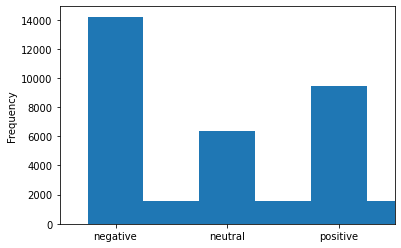

In [6]:
 # importing libraries

import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers
from keras import regularizers


def filter_texts (dataset): # filters texts           
    for i in range(0, dataset.shape[0]):
        comment = re.sub('[^a-zA-Z0-9\s@]', ' ', dataset['content'][i])
        comment = comment.lower()
        comment = comment.split()
        comment = [j for j in comment if len(j) > 1]
        comment = ' '.join(word for word in comment if not word.startswith('@'))
        dataset['content'][i] = comment
    return dataset

dataset = pd.read_csv('train_data.csv')

# analyzing the keywords

y = dataset.iloc[:, 0].values

keywords = []

for i in range (0,30000):
    if not(y[i] in keywords):
        keywords.append(y[i])


for i in range(0,30000):
    if (y[i]=='empty' or y[i]=='sadness' or y[i]=='worry' or y[i]=='hate' or y[i]=='anger'):
        y[i] = 'negative'
        
    elif y[i] =='neutral' :
        y[i] = 'neutral'
        
    else:
        y[i] = 'positive'
        
        
#filtering the texts

dataset = filter_texts(dataset)


# visualizing final dataset

dataset['sentiment'].value_counts().sort_index().plot.bar()


dataset['content'].str.len().plot.hist()

#tokenizing
    

tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(dataset['content'].values)

X = tokenizer.texts_to_sequences(dataset['content'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length


# Model Designing

model = Sequential()
model.add(Embedding(5000, 512, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(300, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)))


adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

# encoding the sentiments
y = pd.get_dummies(dataset['sentiment']).values
[print(dataset['sentiment'][i], y[i]) for i in range(0,15)]

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



# fitting the model
batch_size = 30
epochs = 30

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle = True, validation_data = (X_test,y_test))


#visualizing learning process
plt.plot(history.history['accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()



model.save('18thapril220.h5')


#prediction

predictions = model.predict(X_test)
[print(dataset['content'][i], predictions[i], y_test[i]) for i in range(0, 5)]


#visualizing results

pos_count, neu_count, neg_count = 0, 0, 0
real_pos, real_neu, real_neg = 0, 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==2:
        pos_count += 1
    elif np.argmax(prediction)==1:
        neu_count += 1
    else:
        neg_count += 1
    
    if np.argmax(y_test[i])==2:
        real_pos += 1
    elif np.argmax(y_test[i])==1:    
        real_neu += 1
    else:
        real_neg +=1

print('Positive predictions:', pos_count)
print('Neutral predictions:', neu_count)
print('Negative predictions:', neg_count)
print('Real positive:', real_pos)
print('Real neutral:', real_neu)
print('Real negative:', real_neg)



# testing using self made comments
cmnt = ["@sakibchowdhury : you are bullshit ", 
        "there is no God",
        "i'm really sad",
        "your service is good", 
        "life is beautiful",
        "i really hate you sakib",
        "go to hell",
        "God sees us",
        "we should love everyone",       
        "you are a dog"]

for i in range(0, len(cmnt)):
        comment = re.sub('[^a-zA-Z0-9\s@]', ' ', cmnt[i])

        comment = comment.lower()
        comment = comment.split()

        comment = [j for j in comment if len(j) > 1]

        comment = ' '.join(word for word in comment if not word.startswith('@'))
        cmnt[i] = comment

X_samp = tokenizer.texts_to_sequences(cmnt)
X_samp = pad_sequences(X_samp,31)
model.predict(X_samp)
# -*- coding: utf-8 -*-

